# MLPR

# Imports

In [12]:
import os
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.calibration import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor

# Metrics, plot and save

In [13]:
dataset_saved = r"C:\Users\luyza\OneDrive\Documentos\spectroscopy_machine_learning_analysis\Processed\PCA"
dataset_save = r"C:\Users\luyza\OneDrive\Documentos\spectroscopy_machine_learning_analysis\Multilayer Perceptron Regression"

In [14]:
def calculate_metrics(y_true, y_pred):
        r2 = r2_score(y_true, y_pred)
        correlation_coefficient = np.corrcoef(y_true, y_pred)[0, 1]
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mean_y_true = np.mean(y_true)
        relative_absolute_error = 100 * (mae / np.mean(np.abs(y_true - mean_y_true)))

        return {
            "R²": r2,
            "Correlation coefficient": correlation_coefficient,
            "RMSE": rmse,
            "MAE": mae,
            "Relative absolute error": relative_absolute_error,
        }

In [15]:
def plot_regression_comparison(y_train, y_pred_train, y_pred_cv, attribute, filter):    
        slope_train, offset_train = np.polyfit(y_train, y_pred_train, 1)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        r2_train = r2_score(y_train, y_pred_train)
        
        slope_cv, offset_cv = np.polyfit(y_train, y_pred_cv, 1)
        rmse_cv = np.sqrt(mean_squared_error(y_train, y_pred_cv))
        r2_cv = r2_score(y_train, y_pred_cv)
        
        metrics_dict = pd.DataFrame({
        'Y': ['Referência', 'Predição'],
        'Slope': [slope_train, slope_cv],
        'Offset': [offset_train, offset_cv],
        'RMSE': [rmse_train, rmse_cv],
        'R²': [r2_train, r2_cv]
        })
        
        plt.figure(figsize=(10, 6))
        
        # Scatter plot for reference values
        plt.scatter(y_train, y_pred_train, color='blue', label='Reference', marker='o', alpha=0.7)
        
        # Scatter plot for predicted values
        plt.scatter(y_train, y_pred_cv, color='red', label='Predicted', marker='o', alpha=0.7)
        
        plt.xlabel("Reference")
        plt.ylabel("Predicted")
        plt.title(f"{filter + " - " + attribute}: Reference vs. Predicted (CV)")
        plt.grid(True)
        plt.text(0.05, 0.95, f'Reference - Slope: {slope_train:.2f}, Offset: {offset_train:.2f}, RMSE: {rmse_train:.2f}, R²: {r2_train:.2f}\nPredicted - Slope: {slope_cv:.2f}, Offset: {offset_cv:.2f}, RMSE: {rmse_cv:.2f}, R²: {r2_cv:.2f}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
        plt.show()
        
        return metrics_dict


In [16]:
def plot_test_predictions(y_true_test, y_pred_test):
        # Calcular slope, offset, R² e RMSE
        model = LinearRegression().fit(y_pred_test.reshape(-1, 1), y_true_test)
        slope = model.coef_[0]
        offset = model.intercept_
        y_pred_line = model.predict(np.array([y_true_test.min(), y_true_test.max()]).reshape(-1, 1))
        r2 = r2_score(y_true_test, y_pred_test)
        rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred_test, y_true_test, color='green', label='Dados')
        plt.plot([y_true_test.min(), y_true_test.max()], y_pred_line, color='blue', linestyle='--', label='Linha de Regressão')
        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.title('Predições no Conjunto de Teste')
        plt.legend()
        plt.text(0.05, 0.95, f'Slope: {slope:.2f}\nOffset: {offset:.2f}\nR²: {r2:.2f}\nRMSE: {rmse:.2f}', 
                transform=plt.gca().transAxes, verticalalignment='top')
        plt.tight_layout()
        plt.show()

        metrics_dict = pd.DataFrame({
        'Y': ['Validação'],
        'R²': [r2],
        'RMSE': [rmse],
        'Offset': [offset],
        'Slope': [slope]
        })

        return metrics_dict

In [17]:
global plot_infos_msc 
global plot_infos_snv 
global plot_infos_sg 

plot_infos_msc = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'RMSE','Offset','Slope'])
plot_infos_snv = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'RMSE','Offset','Slope'])
plot_infos_sg = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'RMSE','Offset','Slope'])

def add_plot_infos(plot_infos_pre, plot_infos_df, attribute):
    if plot_infos_pre.empty:
        plot_infos_df['Attribute'] = attribute
        return plot_infos_df.copy()
    
    plot_infos_df = plot_infos_df.copy()
    plot_infos_df['Attribute'] = attribute

    plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)

    return plot_infos_pre


In [18]:
target_variables = ["SST", "PH", "UBS (%)", "FIRMEZA (N)", "AT"]

def load_filtered_data(filter_type):
    calib_path = os.path.join(dataset_saved, f"{filter_type}_processed_calibracao.xlsx")
    valid_path = os.path.join(dataset_saved, f"{filter_type}_processed_validacao.xlsx")
    
    df_calib = pd.read_excel(calib_path)
    df_valid = pd.read_excel(valid_path)
    
    return df_calib, df_valid

In [19]:
def save_metrics(filter_name):
    if filter_name == "MSC":    
        plot_infos_msc.to_excel(os.path.join(dataset_save, f"SVMR_metrics_{filter_name}.xlsx"), index=False),
    elif filter_name == "SG":
        plot_infos_sg.to_excel(os.path.join(dataset_save, f"SVMR_metrics_{filter_name}.xlsx"), index=False)
    else:
        plot_infos_snv.to_excel(os.path.join(dataset_save, f"SVMR_metrics_{filter_name}.xlsx"), index=False)


# Main

In [20]:
def MLPR(X_train, y_train, X_test, y_test, attribute, filter_name, hyperparameters):
    global plot_infos_msc, plot_infos_snv, plot_infos_sg

    pipeline = make_pipeline(
        StandardScaler(),
        MLPRegressor(**hyperparameters, random_state=42)
    )

    pipeline.fit(X_train, y_train)

    y_train_pred = pipeline.predict(X_train)
    training_metrics = calculate_metrics(y_train, y_train_pred)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)  
    y_train_cv = cross_val_predict(pipeline, X_train, y_train, cv=kf)
    cv_metrics = calculate_metrics(y_train, y_train_cv)

    y_pred_val = pipeline.predict(X_test)
    validation_metrics = calculate_metrics(y_test, y_pred_val)
    
    metrics_df_cal = plot_regression_comparison(y_train, y_train_pred, y_train_cv, attribute, filter_name)
    metrics_df_val = plot_test_predictions(y_test, y_pred_val)
    
    metrics_df = pd.DataFrame({
        "Attribute": [attribute, attribute, attribute],
        "Y": ["Training", "Cross-Validation", "Validation"],
        "R²": [training_metrics["R²"], cv_metrics["R²"], validation_metrics["R²"]],
        "Correlation coefficient": [training_metrics["Correlation coefficient"], cv_metrics["Correlation coefficient"], validation_metrics["Correlation coefficient"]],
        "RMSE": [training_metrics["RMSE"], cv_metrics["RMSE"], validation_metrics["RMSE"]],
        "MAE": [training_metrics["MAE"], cv_metrics["MAE"], validation_metrics["MAE"]],
        "Relative absolute error": [training_metrics["Relative absolute error"], cv_metrics["Relative absolute error"], validation_metrics["Relative absolute error"]]
    })
    
    if filter_name == "MSC":
        plot_infos_msc = add_plot_infos(plot_infos_msc, metrics_df, attribute)
    elif filter_name == "SNV":
        plot_infos_snv = add_plot_infos(plot_infos_snv, metrics_df, attribute)
    elif filter_name == "SG":
        plot_infos_sg = add_plot_infos(plot_infos_sg, metrics_df, attribute)


# MSC

In [21]:
data_msc_calib, data_msc_valid = load_filtered_data("MSC")
msc_calib = data_msc_calib.iloc[:,6:]
msc_valid = data_msc_valid.iloc[:,6:]

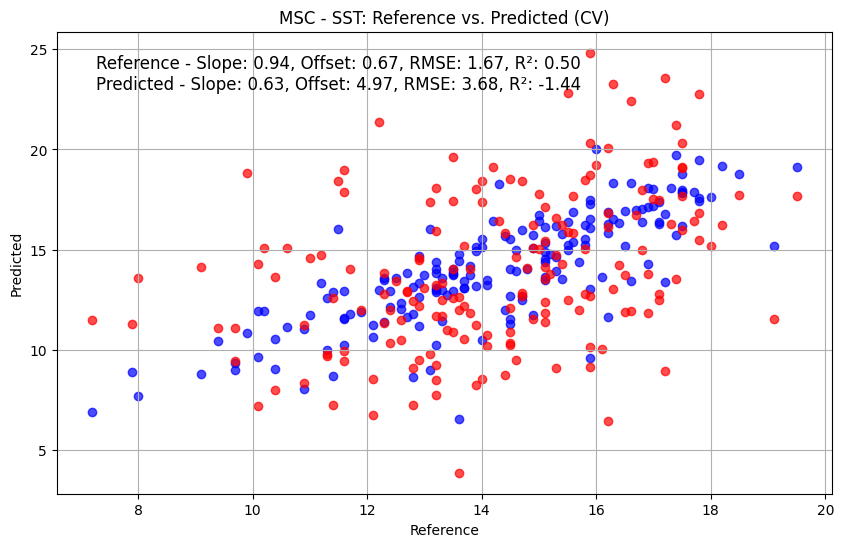

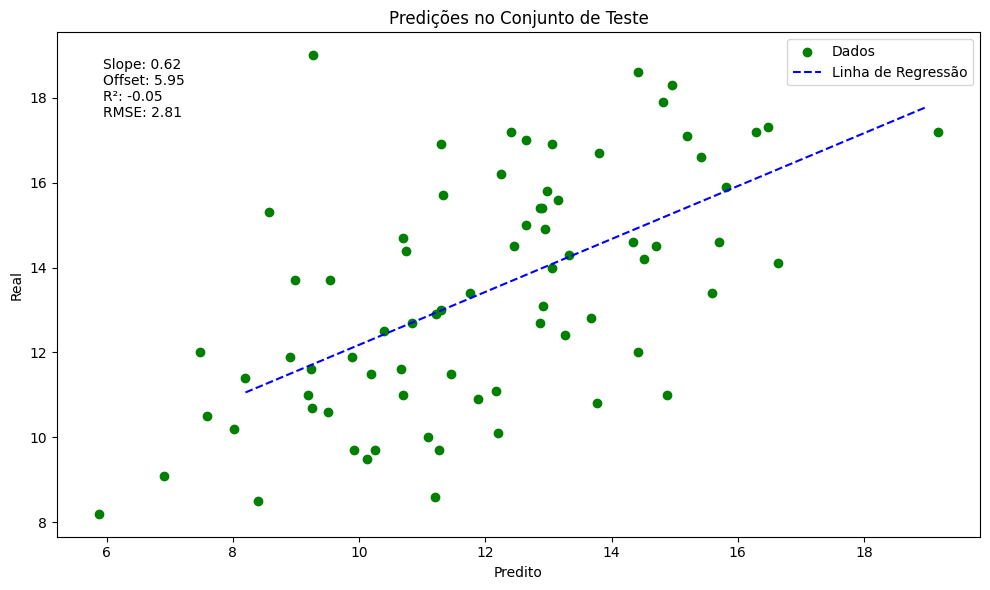

In [22]:
mlpr_sst_params = {
    'hidden_layer_sizes': (50, 100, 100,50,50), 
    'activation': 'relu', 
    'solver': 'adam',
    'n_iter_no_change': 1000,
    'max_iter': 8000,    
    'alpha': 0.001,
    'learning_rate': 'constant',   
    'tol': 1e-4,  
    'early_stopping': True,               
    'batch_size': 64  
}

results = MLPR(msc_calib, data_msc_calib['SST'], msc_valid, data_msc_valid['SST'], 'SST', 'MSC', mlpr_sst_params)

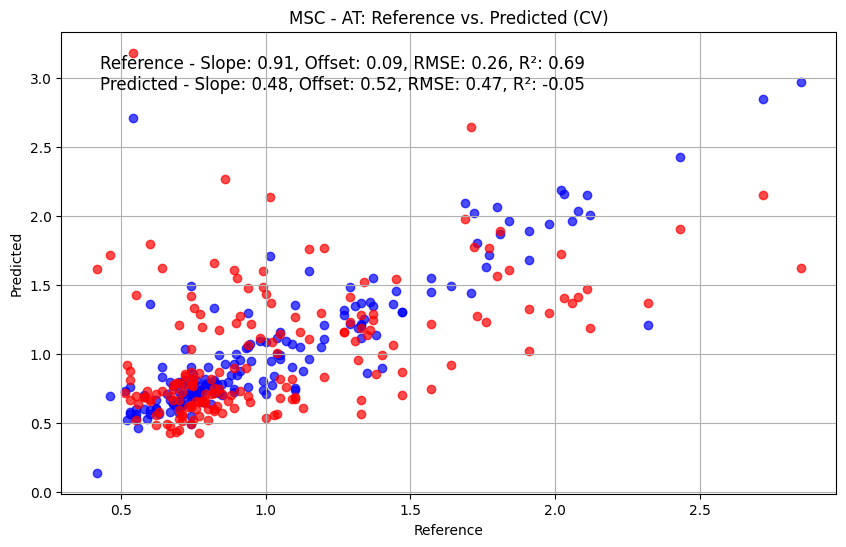

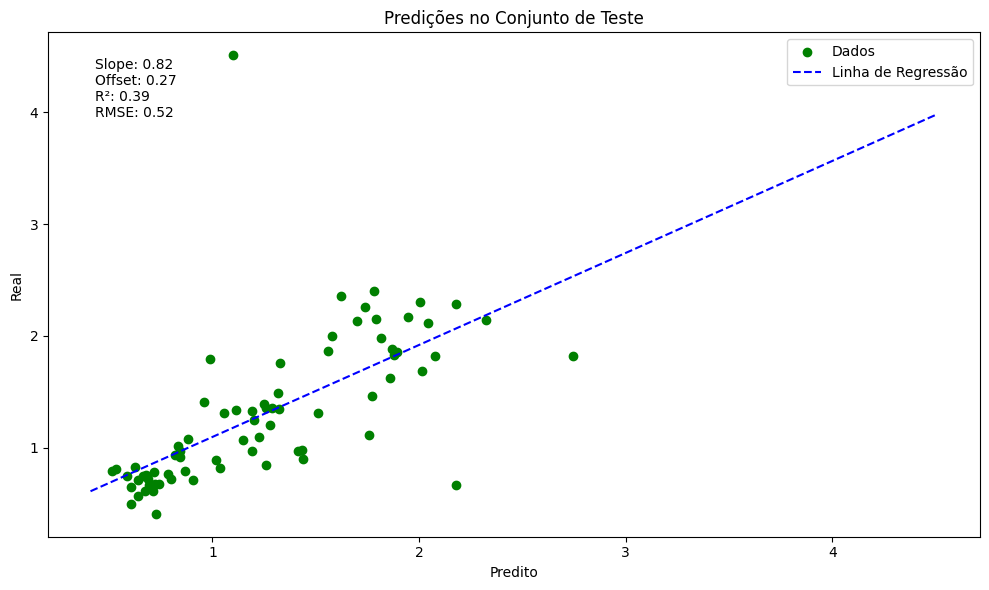

In [23]:
mlpr_at_params = {
    'hidden_layer_sizes': (50, 50, 50,50,50), 
    'activation': 'relu', 
    'solver': 'adam',
    'n_iter_no_change': 500,
    'max_iter': 8000,    
    'alpha': 0.001,
    'learning_rate': 'constant',   
    'tol': 1e-4,  
    'early_stopping': True,               
    'batch_size': 64  
}

results = MLPR(msc_calib, data_msc_calib['AT'], msc_valid, data_msc_valid['AT'], 'AT', 'MSC', mlpr_at_params)

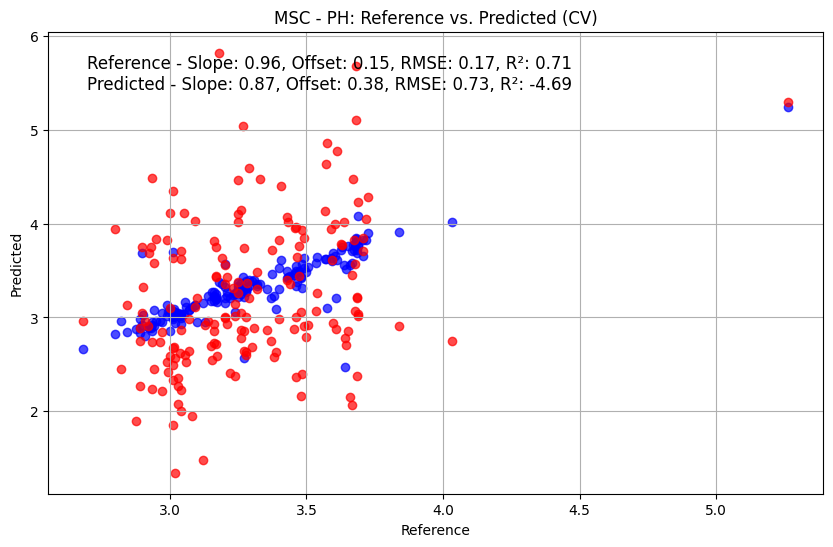

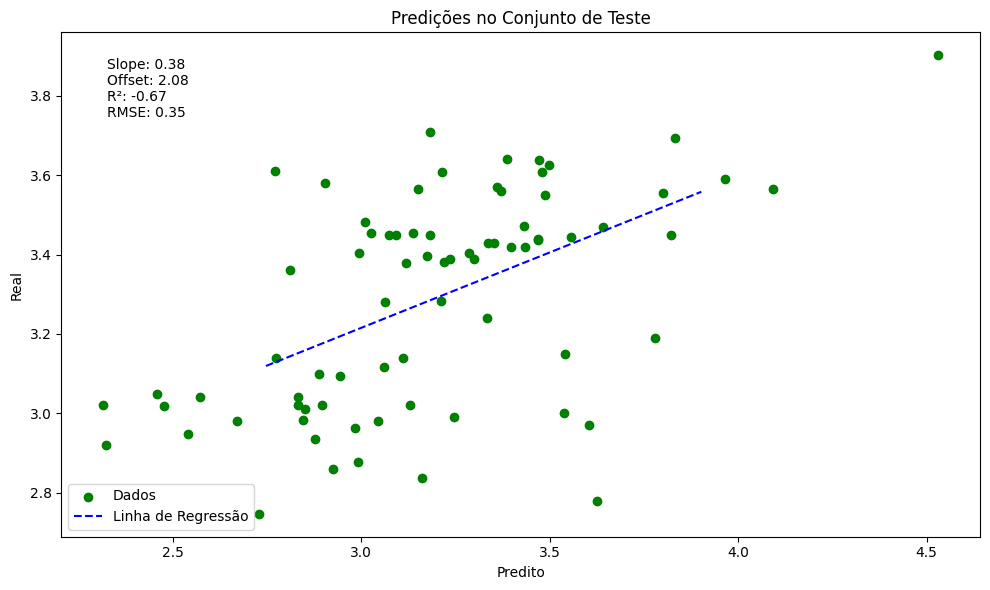

In [24]:
mlpr_ph_params = {
    'hidden_layer_sizes': (50, 50, 50,50,50), 
    'activation': 'relu', 
    'solver': 'adam',
    'n_iter_no_change': 500,
    'max_iter': 8000,    
    'alpha': 0.001,
    'learning_rate': 'constant',   
    'tol': 1e-4,  
    'early_stopping': True,               
    'batch_size': 64  
}
results = MLPR(msc_calib, data_msc_calib['PH'], msc_valid, data_msc_valid['PH'], 'PH', 'MSC', mlpr_ph_params)

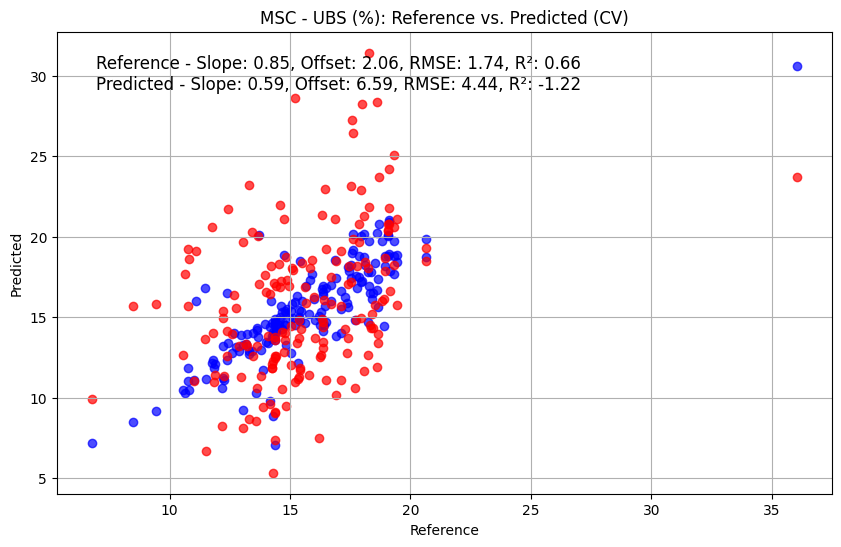

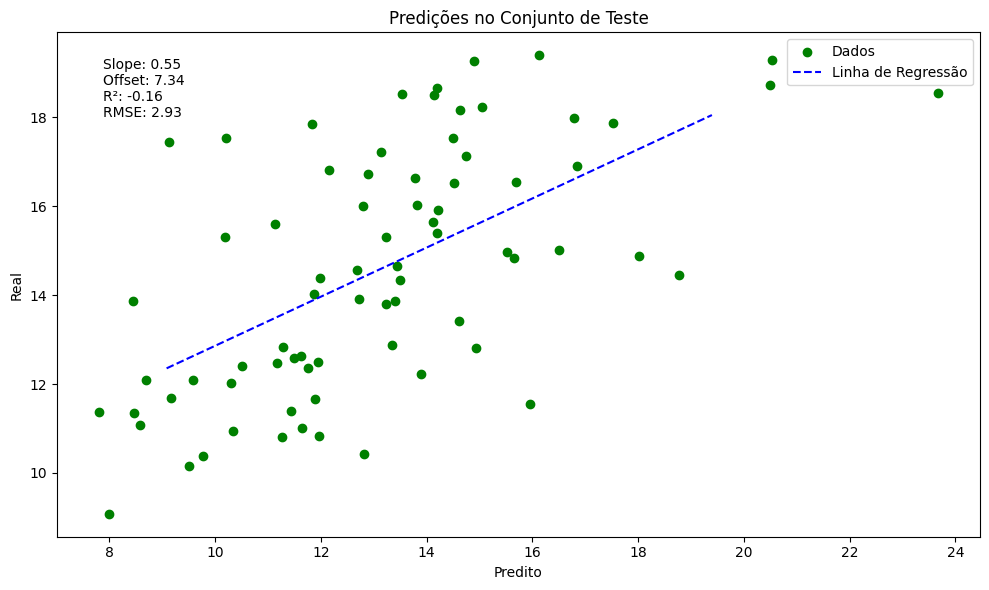

In [25]:
mlpr_ubs_params = {
    'hidden_layer_sizes': (50, 50, 50,50,50), 
    'activation': 'relu', 
    'solver': 'adam',
    'n_iter_no_change': 500,
    'max_iter': 8000,    
    'alpha': 0.001,
    'learning_rate': 'constant',   
    'tol': 1e-4,  
    'early_stopping': True,               
    'batch_size': 64  
}

results = MLPR(msc_calib, data_msc_calib['UBS (%)'], msc_valid, data_msc_valid['UBS (%)'], 'UBS (%)', 'MSC', mlpr_ubs_params)

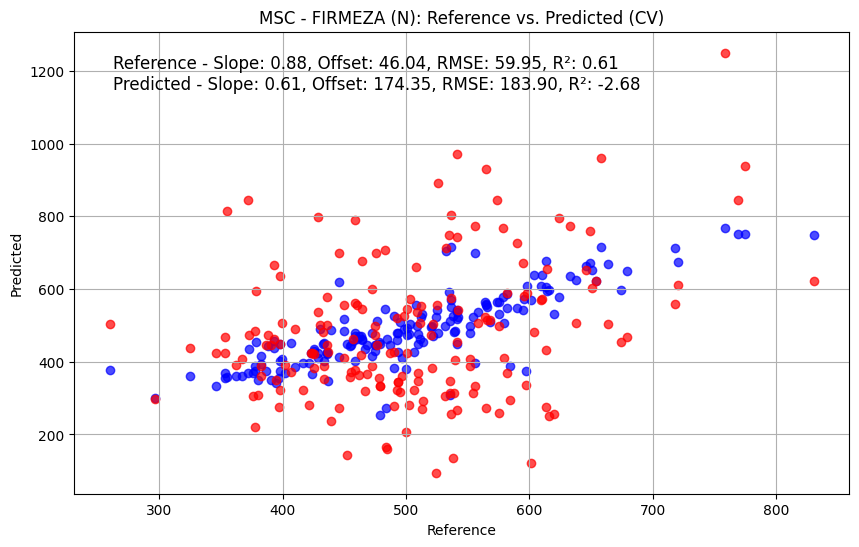

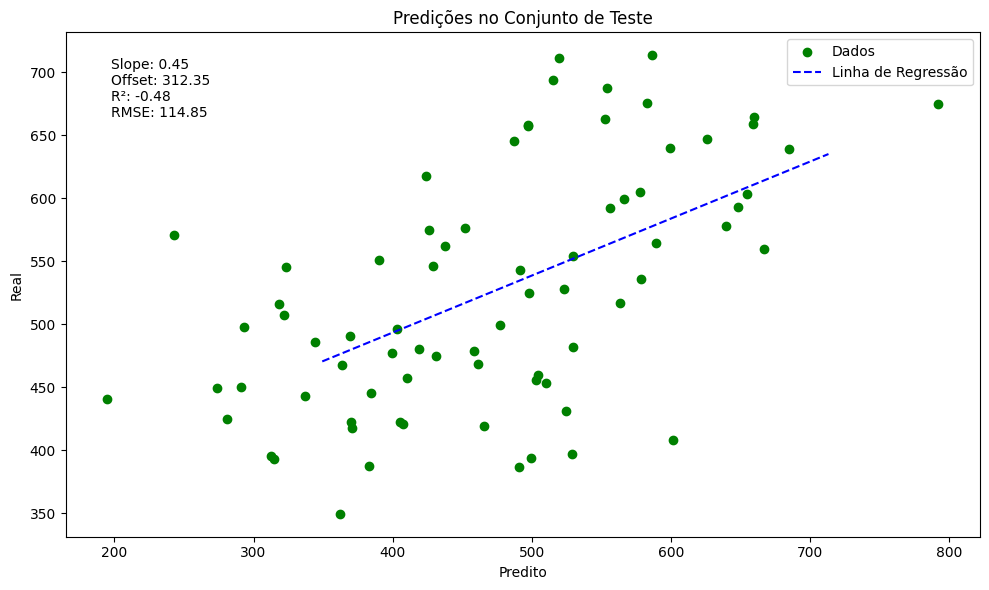

In [26]:
mlpr_f_params = {
    'hidden_layer_sizes': (50, 50, 50,50,50), 
    'activation': 'relu', 
    'solver': 'adam',
    'n_iter_no_change': 500,
    'max_iter': 8000,    
    'alpha': 0.001,
    'learning_rate': 'constant',   
    'tol': 1e-4,  
    'early_stopping': True,               
    'batch_size': 64  
}

results = MLPR(msc_calib, data_msc_calib['FIRMEZA (N)'], msc_valid, data_msc_valid['FIRMEZA (N)'], 'FIRMEZA (N)', 'MSC', mlpr_f_params)

# SNV

In [27]:
data_snv_calib, data_snv_valid = load_filtered_data("SNV")
snv_calib = data_snv_calib.iloc[:,6:]
snv_valid = data_snv_valid.iloc[:,6:]

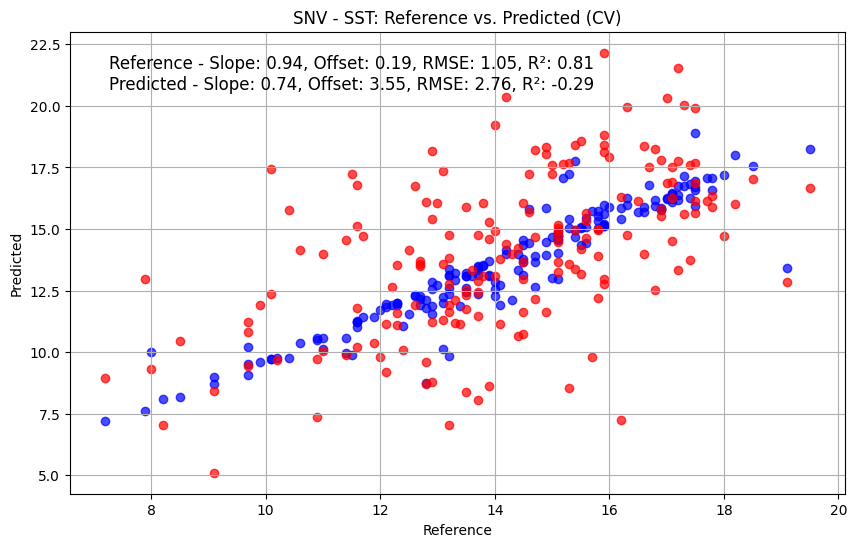

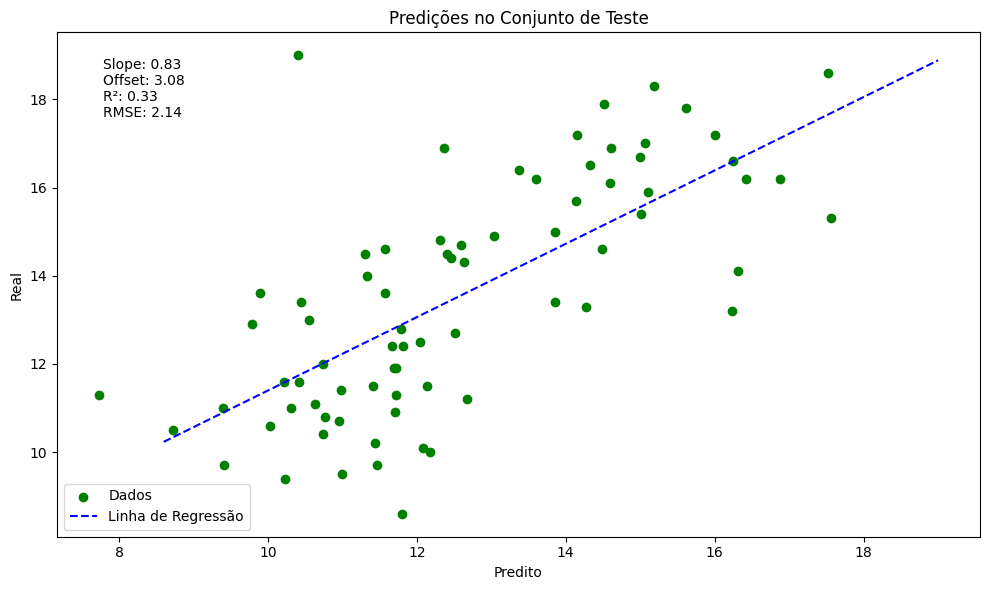

In [28]:
mlpr_snvsst_params = {
    'hidden_layer_sizes': (50, 50, 50,50,50), 
    'activation': 'relu', 
    'solver': 'adam',
    'n_iter_no_change': 500,
    'max_iter': 8000,    
    'alpha': 0.001,
    'learning_rate': 'constant',   
    'tol': 1e-4,  
    'early_stopping': True,               
    'batch_size': 64  
}

results = MLPR(snv_calib, data_snv_calib['SST'], snv_valid, data_snv_valid['SST'], 'SST', 'SNV', mlpr_snvsst_params)

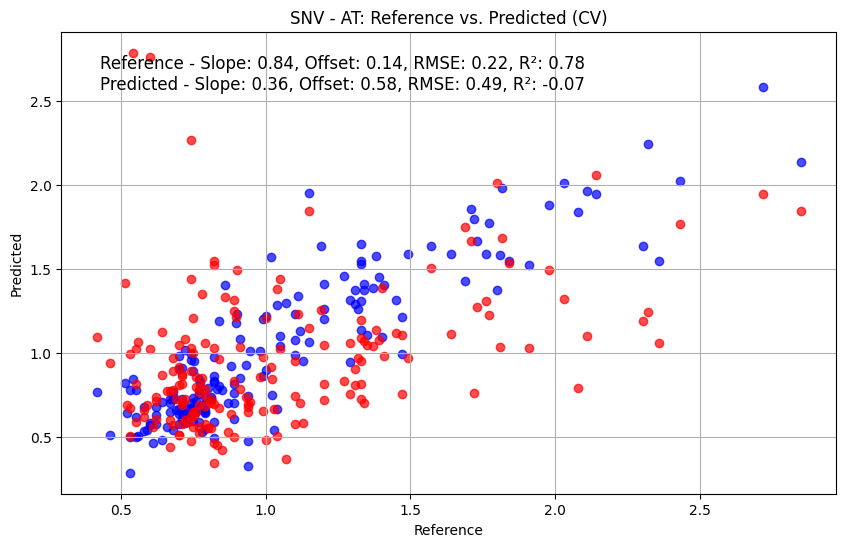

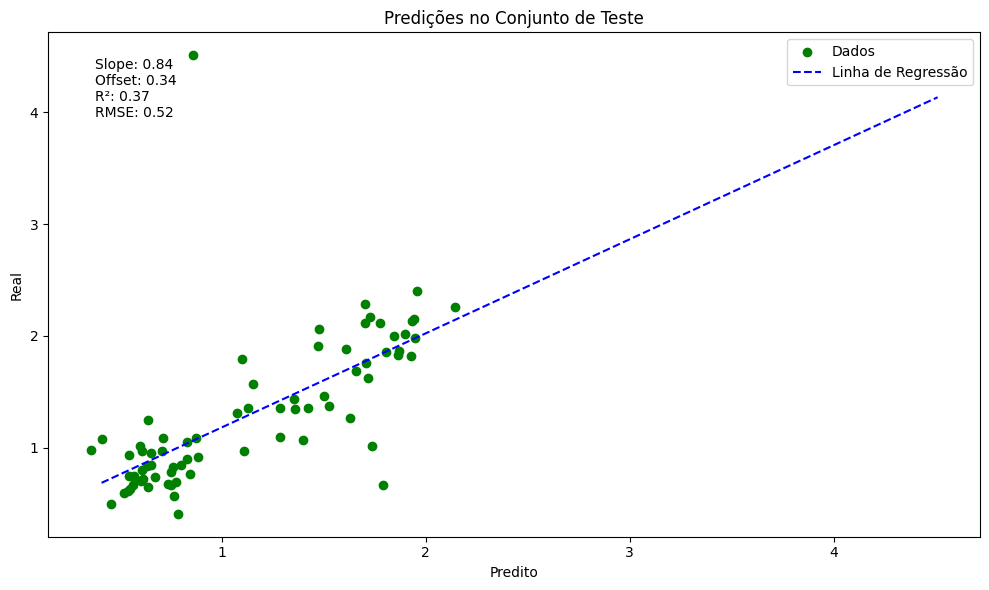

In [29]:
mlpr_snvat_params = {
    'hidden_layer_sizes': (50, 50, 50,50,50), 
    'activation': 'relu', 
    'solver': 'adam',
    'n_iter_no_change': 500,
    'max_iter': 8000,    
    'alpha': 0.001,
    'learning_rate': 'constant',   
    'tol': 1e-4,  
    'early_stopping': True,               
    'batch_size': 64  
}

results = MLPR(snv_calib, data_snv_calib['AT'], snv_valid, data_snv_valid['AT'], 'AT', 'SNV', mlpr_snvat_params)

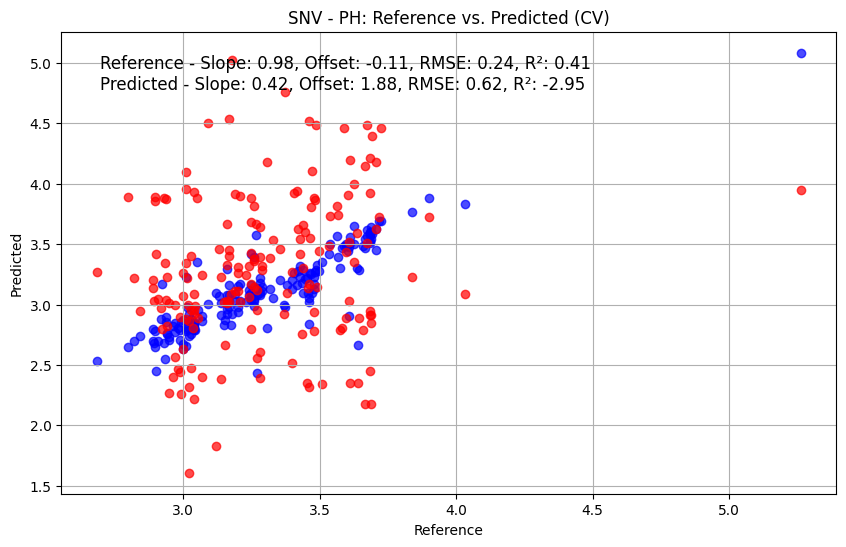

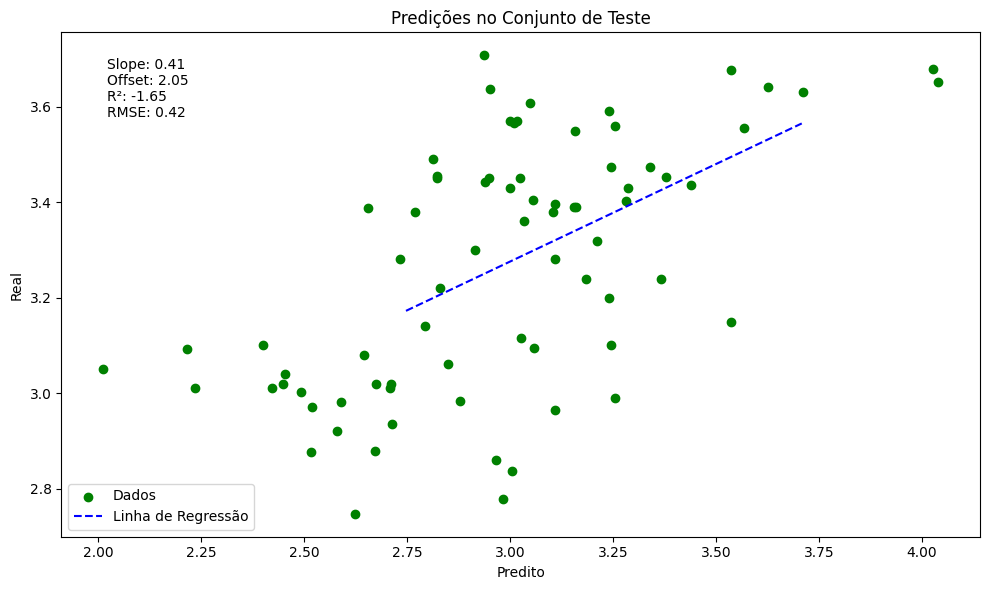

In [30]:
mlpr_snvph_params = {
    'hidden_layer_sizes': (50, 50, 50,50,50), 
    'activation': 'relu', 
    'solver': 'adam',
    'n_iter_no_change': 500,
    'max_iter': 8000,    
    'alpha': 0.001,
    'learning_rate': 'constant',   
    'tol': 1e-4,  
    'early_stopping': True,               
    'batch_size': 64  
}

results = MLPR(snv_calib, data_snv_calib['PH'], snv_valid, data_snv_valid['PH'], 'PH', 'SNV', mlpr_snvph_params)

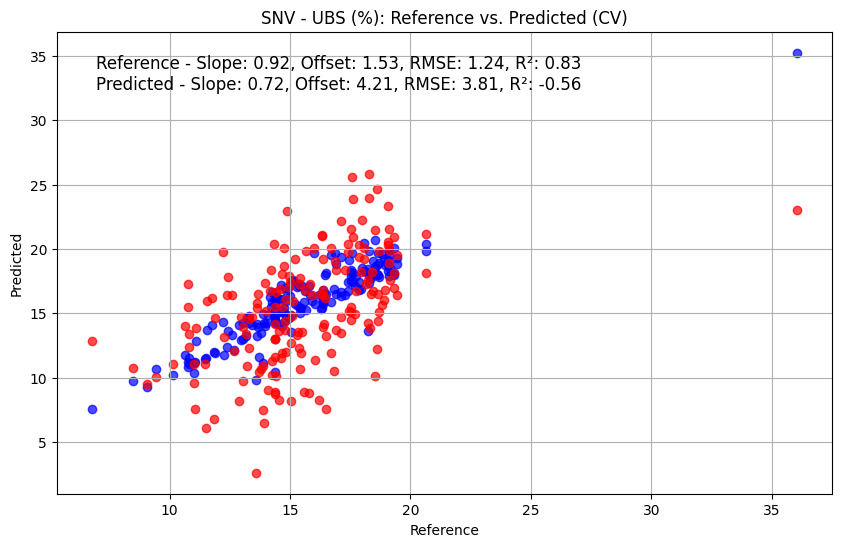

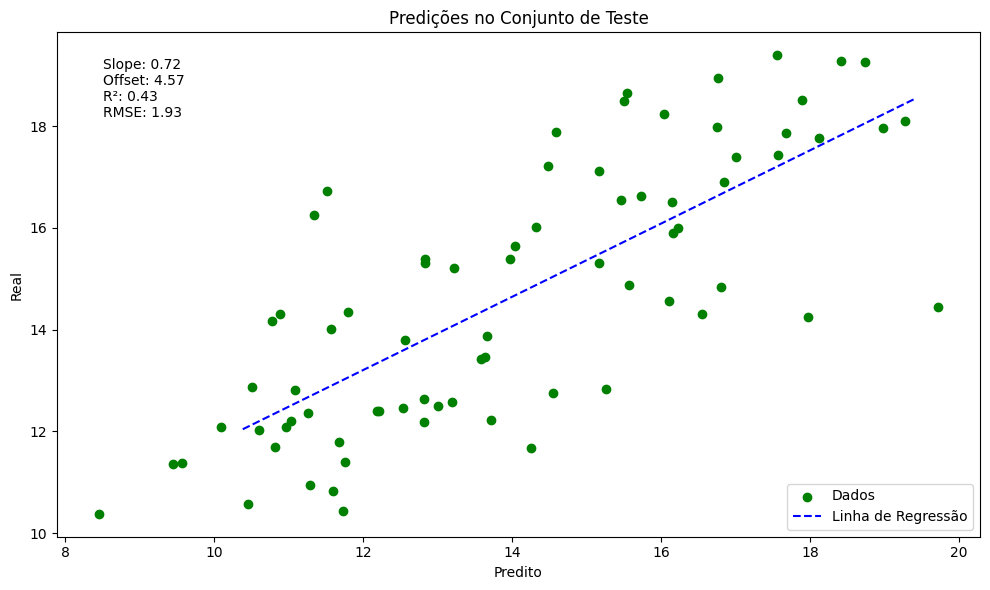

In [31]:
mlpr_snvubs_params = {
    'hidden_layer_sizes': (50, 50, 50,50,50), 
    'activation': 'relu', 
    'solver': 'adam',
    'n_iter_no_change': 500,
    'max_iter': 8000,    
    'alpha': 0.001,
    'learning_rate': 'constant',   
    'tol': 1e-4,  
    'early_stopping': True,               
    'batch_size': 64  
}

results = MLPR(snv_calib, data_snv_calib['UBS (%)'], snv_valid, data_snv_valid['UBS (%)'], 'UBS (%)', 'SNV', mlpr_snvubs_params)

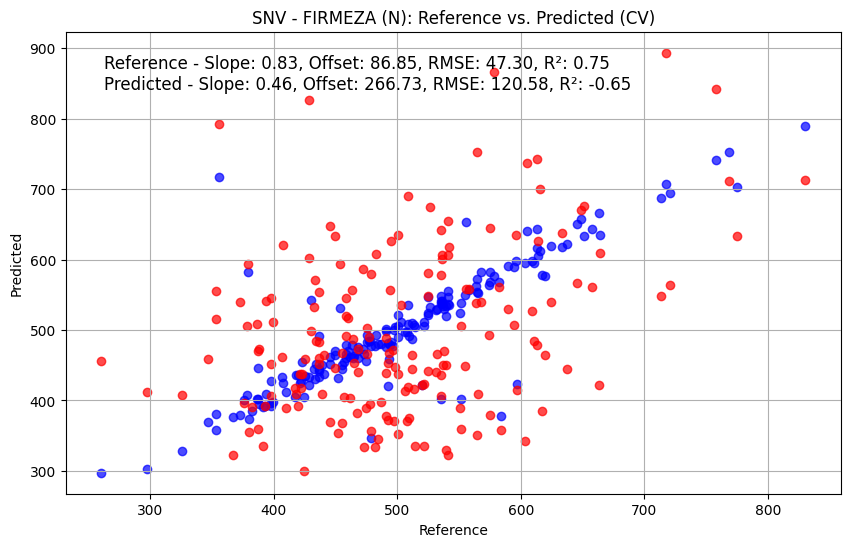

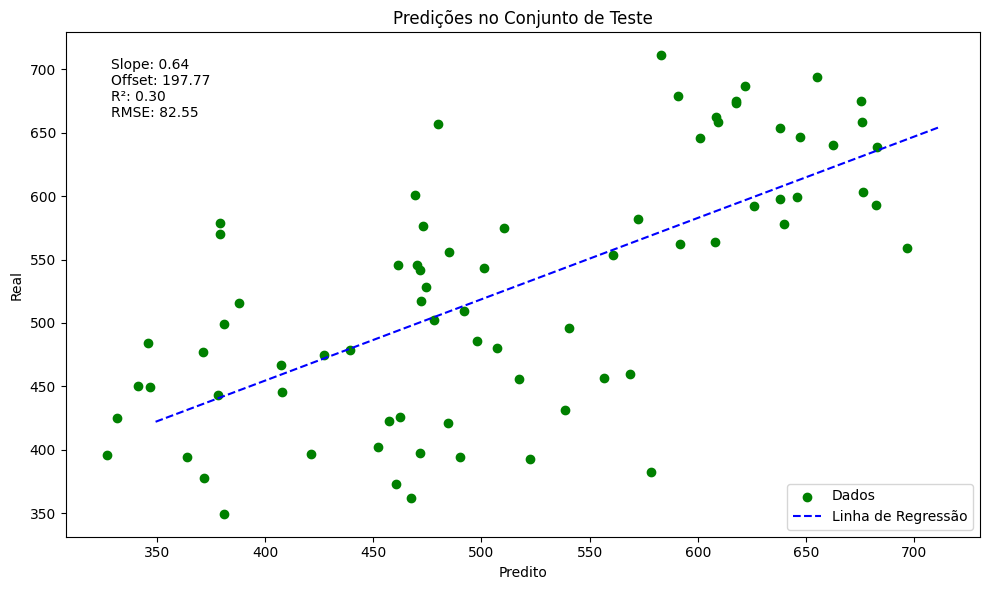

In [32]:
mlpr_snvf_params = {
    'hidden_layer_sizes': (50, 50, 50,50,50), 
    'activation': 'relu', 
    'solver': 'adam',
    'n_iter_no_change': 500,
    'max_iter': 8000,    
    'alpha': 0.001,
    'learning_rate': 'constant',   
    'tol': 1e-4,  
    'early_stopping': True,               
    'batch_size': 64  
}

results = MLPR(snv_calib, data_snv_calib['FIRMEZA (N)'], snv_valid, data_snv_valid['FIRMEZA (N)'], 'FIRMEZA (N)', 'SNV', mlpr_snvf_params)

# SG

In [33]:
data_sg_calib, data_sg_valid = load_filtered_data("SG")
sg_calib = data_sg_calib.iloc[:,6:]
sg_valid = data_sg_valid.iloc[:,6:]

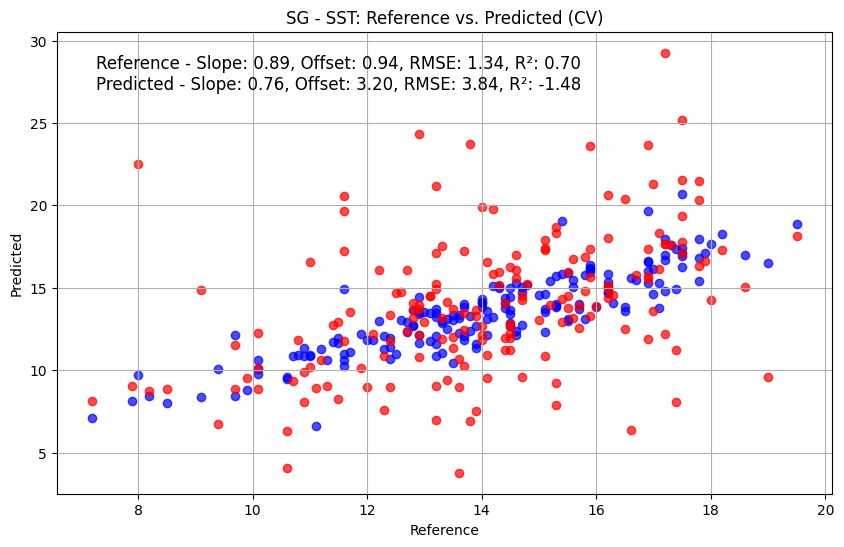

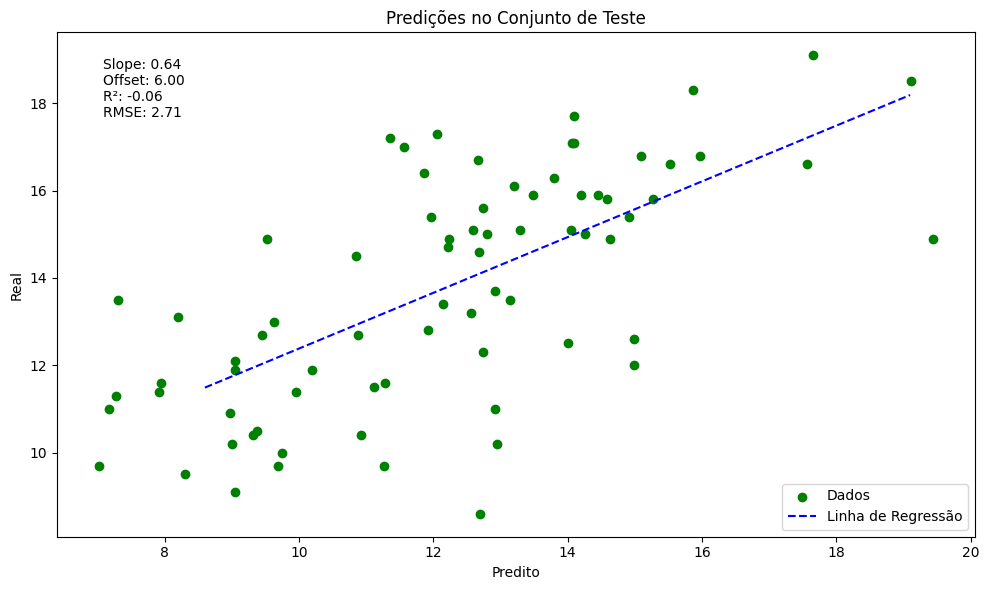

In [34]:
mlpr_sgsst_params = {
    'hidden_layer_sizes': (50, 50, 50,50,50), 
    'activation': 'relu', 
    'solver': 'adam',
    'n_iter_no_change': 500,
    'max_iter': 8000,    
    'alpha': 0.001,
    'learning_rate': 'constant',   
    'tol': 1e-4,  
    'early_stopping': True,               
    'batch_size': 64  
}

results = MLPR(sg_calib, data_sg_calib['SST'], sg_valid, data_sg_valid['SST'], 'SST', 'SG', mlpr_sgsst_params)

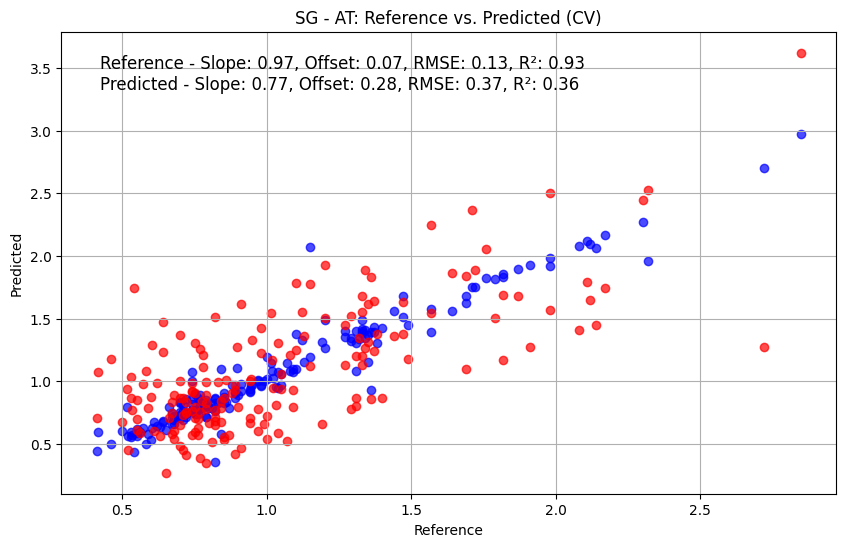

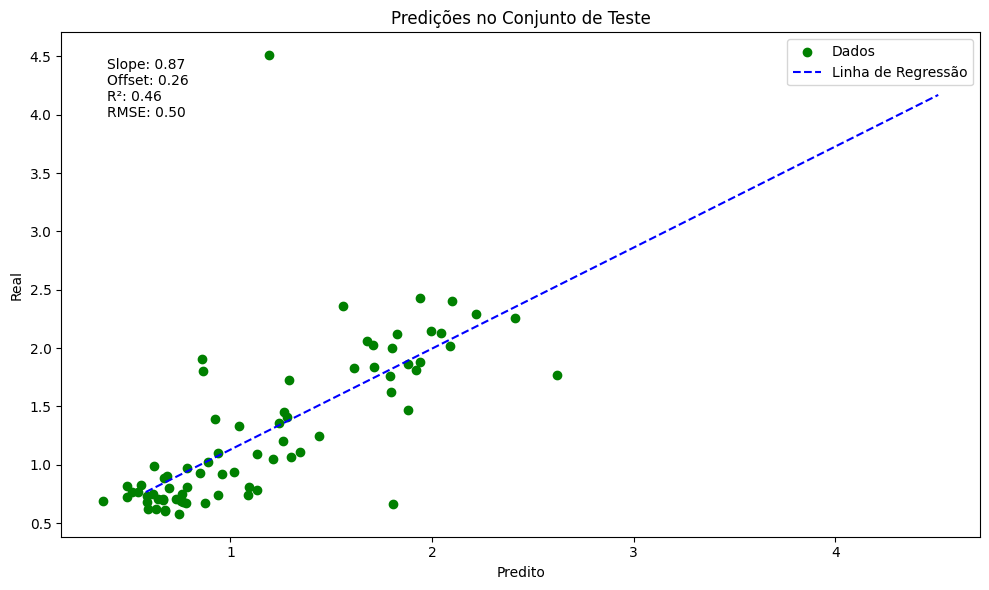

In [35]:
mlpr_sgat_params = {
    'hidden_layer_sizes': (50, 50, 50,50,50), 
    'activation': 'relu', 
    'solver': 'adam',
    'n_iter_no_change': 500,
    'max_iter': 8000,    
    'alpha': 0.001,
    'learning_rate': 'constant',   
    'tol': 1e-4,  
    'early_stopping': True,               
    'batch_size': 64  
}

results = MLPR(sg_calib, data_sg_calib['AT'], sg_valid, data_sg_valid['AT'], 'AT', 'SG', mlpr_sgat_params)

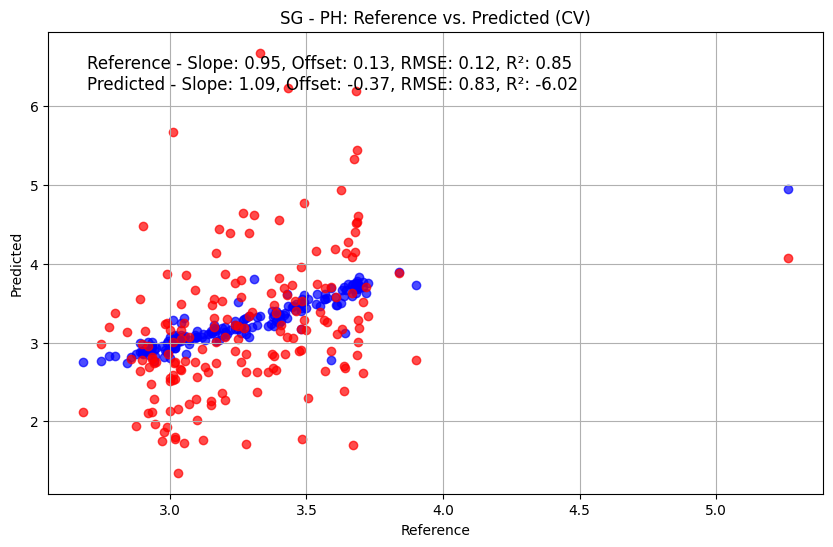

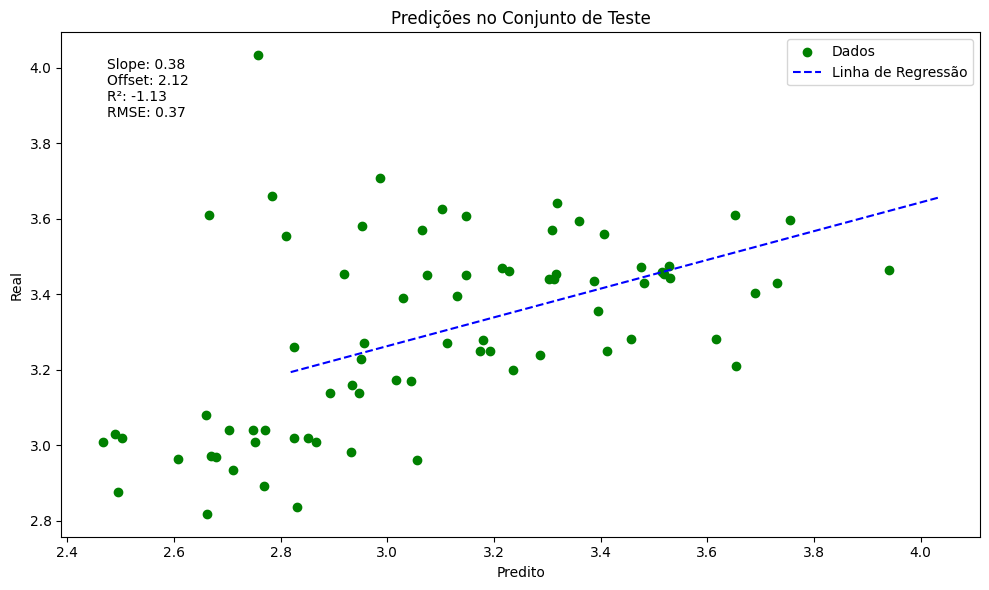

In [36]:
mlpr_sgph_params = {
    'hidden_layer_sizes': (50, 50, 50,50,50), 
    'activation': 'relu', 
    'solver': 'adam',
    'n_iter_no_change': 500,
    'max_iter': 8000,    
    'alpha': 0.001,
    'learning_rate': 'constant',   
    'tol': 1e-4,  
    'early_stopping': True,               
    'batch_size': 64  
}

results = MLPR(sg_calib, data_sg_calib['PH'], sg_valid, data_sg_valid['PH'], 'PH', 'SG', mlpr_sgph_params)

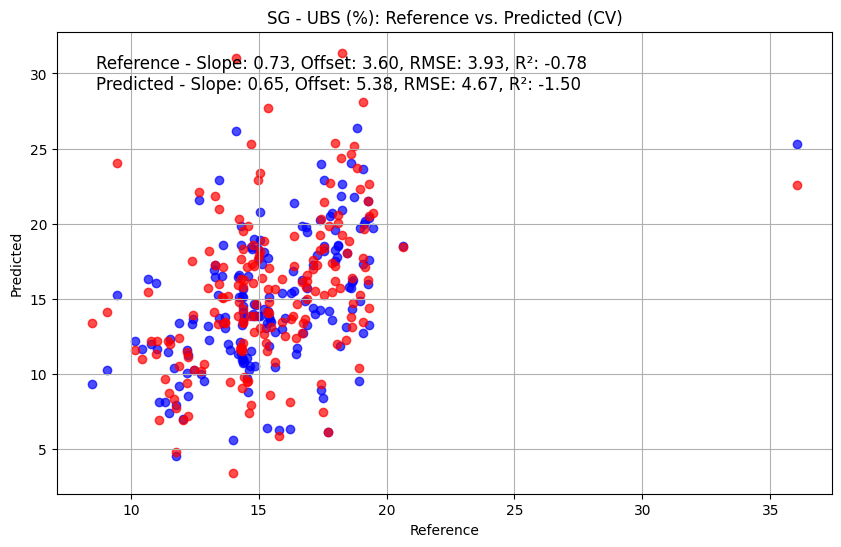

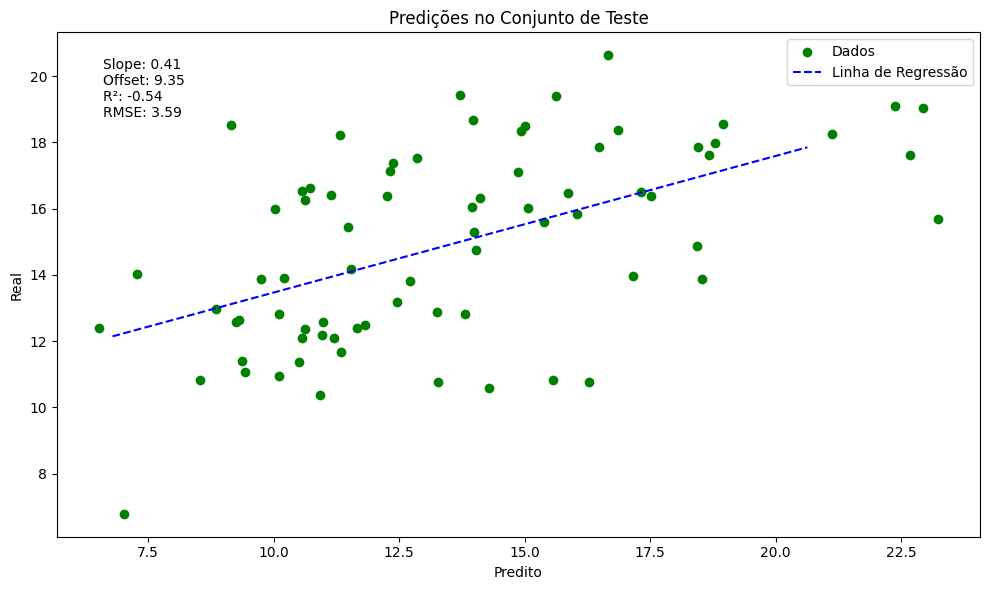

In [37]:
mlpr_sgubs_params = {
    'hidden_layer_sizes': (50, 50, 50,50,50), 
    'activation': 'relu', 
    'solver': 'adam',
    'n_iter_no_change': 500,
    'max_iter': 8000,    
    'alpha': 0.001,
    'learning_rate': 'constant',   
    'tol': 1e-4,  
    'early_stopping': True,               
    'batch_size': 64  
}

results = MLPR(sg_calib, data_sg_calib['UBS (%)'], sg_valid, data_sg_valid['UBS (%)'], 'UBS (%)', 'SG', mlpr_sgubs_params)

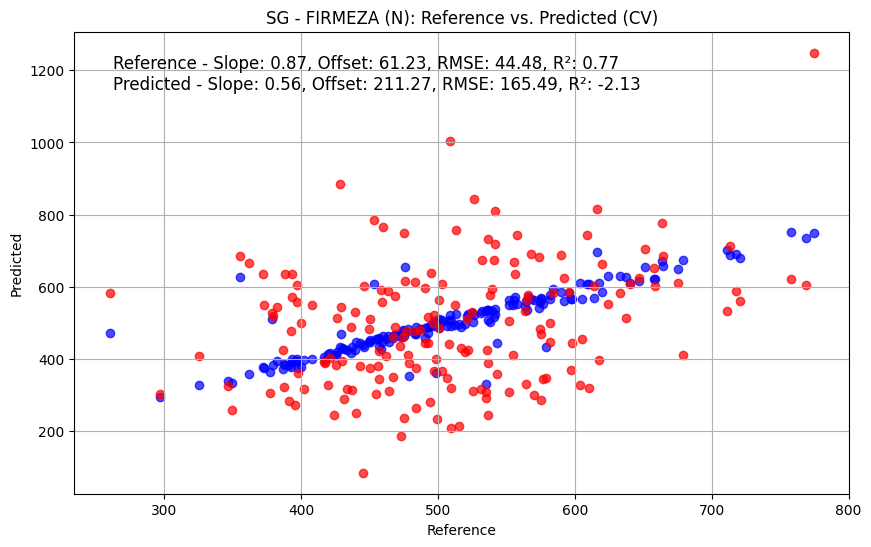

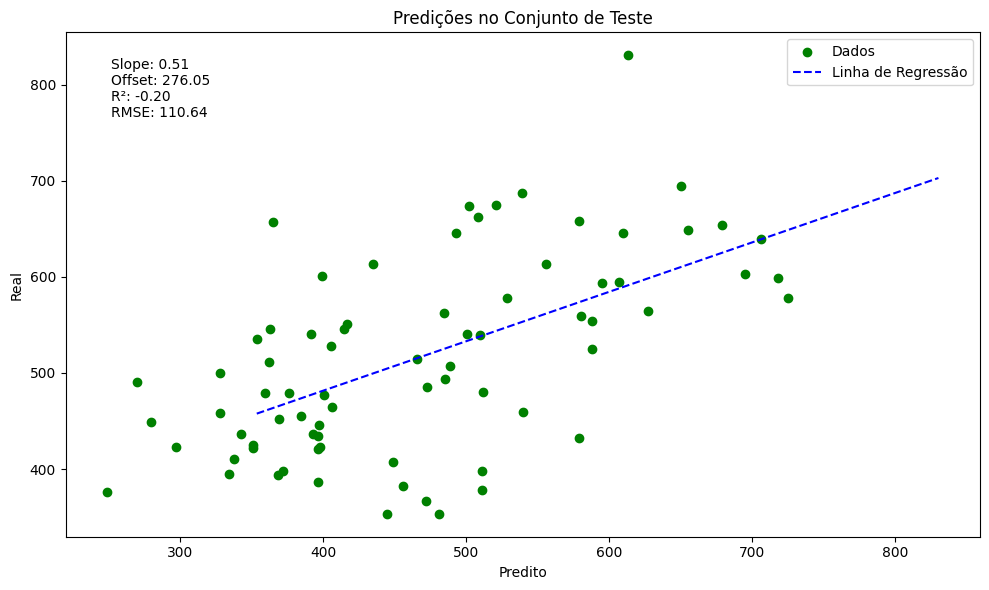

In [38]:
mlpr_sgf_params = {
    'hidden_layer_sizes': (50, 50, 50,50,50), 
    'activation': 'relu', 
    'solver': 'adam',
    'n_iter_no_change': 500,
    'max_iter': 8000,    
    'alpha': 0.001,
    'learning_rate': 'constant',   
    'tol': 1e-4,  
    'early_stopping': True,               
    'batch_size': 64  
}

results = MLPR(sg_calib, data_sg_calib['FIRMEZA (N)'], sg_valid, data_sg_valid['FIRMEZA (N)'], 'FIRMEZA (N)', 'SG', mlpr_sgf_params)